In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

model_name = 'PORT_GRU'

2023-03-20 17:01:42.391527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 17:01:43.633949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-20 17:01:43.634118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-20 17:01:43.634134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Reads the portuguese words
lines= pd.read_table('br-utf8.txt', names=['words'])
lines.shape

(261798, 1)

In [3]:
lines.sample(5)

,words
119750,eriçaremos
58196,comemorareis
3871,academicizará
165926,lacrei
240147,sublevar


In [4]:
# Lowercase all characters
lines.words = lines.words.apply(lambda x: x.lower())
# Remove quotes
lines.words = lines.words.apply(lambda x: re.sub("'", '', x))
# Add start and end tokens to target sequences
lines.words = lines.words.apply(lambda x : '<'+ x + '>')

lines.sample(5)

,words
53674,<choveriam>
255201,<vadiaria>
77556,<denegásseis>
52610,<charlatanearam>
26736,<argentina>


In [5]:
# Get all chars list
all_chars=set()
for word in lines.words: 
    for char in word: 
        if char not in all_chars: all_chars.add(char)
        
# Word with max lenght
max_length_word=0
for word in lines.words:
    max_length_word = max(len(word), max_length_word)


all_chars.add('_')
num_chars = len(all_chars) + 1

# Dicts to transform chars into index and vice-versa
char_token_index = dict([(char, i+1) for i, char in enumerate(all_chars)])
reverse_char_token_index = dict((i, char) for char, i in char_token_index.items())

# save dictionary to char_to_index.pkl file
with open('models/'+model_name+'/char_to_index.pkl', 'wb') as fp:
    pickle.dump(char_token_index, fp)
    print('Dictionary saved successfully to file')

Dictionary saved successfully to file


In [6]:
X_train, X_test, _, __ = train_test_split(lines.words, lines.words, test_size = 0.2)
print(X_train.shape, X_test.shape)

(209438,) (52360,)


In [7]:
flags = pd.Series(['<start_>', '<_end>'])
X_train = pd.concat([X_train, flags], axis=0)
y_train, y_test = X_train, X_test

In [8]:
def generate_batch(X = X_train, y = y_train, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        # iterate from batch to batch
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_word),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_word),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_word, num_chars),dtype='float32')
            # get the batch elements 
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, char in enumerate(input_text):
                    encoder_input_data[i, t] = char_token_index[char] # encoder input seq
                for t, char in enumerate(target_text):
                    if t < len(target_text) - 1:
                        decoder_input_data[i, t] = char_token_index[char] # decoder input seq
                    if t > 0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t-1, char_token_index[char]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [9]:
latent_dim = 50

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_emb =  Embedding(num_chars, latent_dim, mask_zero=True)(encoder_inputs)
encoder_gru = GRU(latent_dim, return_state=True)
encoder_outputs, encoder_state = encoder_gru(encoder_emb)

2023-03-20 17:01:46.344075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 17:01:46.409601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-20 17:01:46.409652: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-20 17:01:46.410382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [10]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
decoder_emb_layer = Embedding(num_chars, latent_dim, mask_zero = True)
decoder_emb = decoder_emb_layer(decoder_inputs)

decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,  _ = decoder_gru(decoder_emb, initial_state=encoder_state)

# Use a softmax to generate a probability distribution over the target vocabulary for each time step
decoder_dense = Dense(num_chars, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

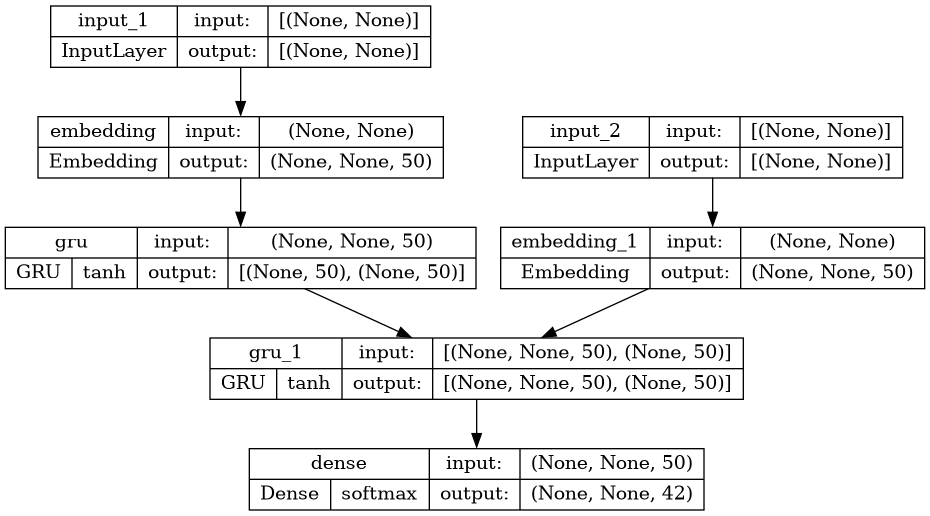

In [11]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

plot_model(model, show_shapes=True, show_layer_activations=True)

In [12]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 10

In [13]:
model.fit(
    generate_batch(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=train_samples//batch_size,
    epochs=epochs,
    validation_data=generate_batch(X_test, y_test, batch_size=batch_size),
    validation_steps=val_samples//batch_size
)

Epoch 1/10
3272/3272 [==============================] - 137s 39ms/step - loss: 1.7917 - acc: 0.4280 - val_loss: 1.3850 - val_acc: 0.5579
Epoch 2/10
3272/3272 [==============================] - 107s 33ms/step - loss: 1.0834 - acc: 0.6553 - val_loss: 0.8509 - val_acc: 0.7221
Epoch 3/10
3272/3272 [==============================] - 108s 33ms/step - loss: 0.6295 - acc: 0.8027 - val_loss: 0.4391 - val_acc: 0.8701
Epoch 4/10
3272/3272 [==============================] - 108s 33ms/step - loss: 0.3539 - acc: 0.8947 - val_loss: 0.2496 - val_acc: 0.9257
Epoch 5/10
3272/3272 [==============================] - 109s 33ms/step - loss: 0.2035 - acc: 0.9413 - val_loss: 0.1393 - val_acc: 0.9612
Epoch 6/10
3272/3272 [==============================] - 109s 33ms/step - loss: 0.1311 - acc: 0.9631 - val_loss: 0.1207 - val_acc: 0.9653
Epoch 7/10
3272/3272 [==============================] - 109s 33ms/step - loss: 0.0900 - acc: 0.9753 - val_loss: 0.1033 - val_acc: 0.9697
Epoch 8/10
3272/3272 [===================

In [14]:
model.save('models/'+model_name+'/por_enc_dec')

INFO:tensorflow:Assets written to: models/PORT_GRU/por_enc_dec/assets


INFO:tensorflow:Assets written to: models/PORT_GRU/por_enc_dec/assets


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 50)     2100        ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 50)     2100        ['input_2[0][0]']                
                                                                                              

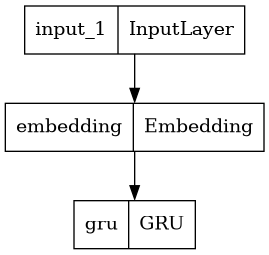

In [16]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_state)
plot_model(encoder_model)

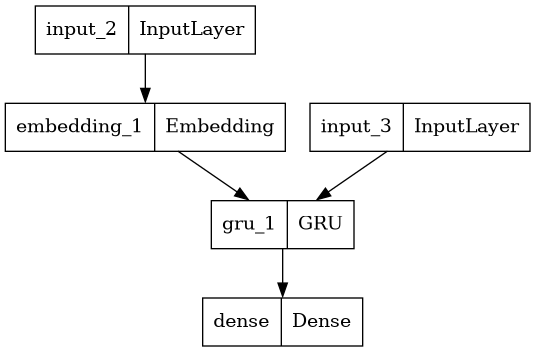

In [17]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input = Input(shape=(latent_dim,))

# Get the embeddings of the decoder sequence
decoder_emb2 = decoder_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, decoder_state2 = decoder_gru(decoder_emb2, initial_state=decoder_state_input)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs, decoder_state_input], [decoder_outputs2, decoder_state2])
plot_model(decoder_model)

In [18]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = char_token_index['<']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, states_value = decoder_model.predict([target_seq, states_value], verbose=0)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_char_token_index[sampled_token_index]
        decoded_sentence += sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == '>' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
    
    return decoded_sentence

In [19]:
train_gen = generate_batch(X_test, y_test, batch_size = 1)
for k in range(15):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('-----------------------------------------')
    print('Input English sentence:', X_test[k:k+1].values[0])
    print('Actual Marathi Translation:', y_test[k:k+1].values[0])
    print('Predicted Marathi Translation:', decoded_sentence)

-----------------------------------------
Input English sentence: <confiscado>
Actual Marathi Translation: <confiscado>
Predicted Marathi Translation: confiscado>
-----------------------------------------
Input English sentence: <repartíssemos>
Actual Marathi Translation: <repartíssemos>
Predicted Marathi Translation: repartíssemos>
-----------------------------------------
Input English sentence: <elevemo>
Actual Marathi Translation: <elevemo>
Predicted Marathi Translation: elevemo>
-----------------------------------------
Input English sentence: <fogo>
Actual Marathi Translation: <fogo>
Predicted Marathi Translation: fogo>
-----------------------------------------
Input English sentence: <blasfemássemos>
Actual Marathi Translation: <blasfemássemos>
Predicted Marathi Translation: blasfemermosse>
-----------------------------------------
Input English sentence: <salivo>
Actual Marathi Translation: <salivo>
Predicted Marathi Translation: salivo>
----------------------------------------

In [20]:
unknown = pd.Series(['<nintendo>', '<arretado>', '<estrombofone>','<tankar>', '<_end>'])
train_gen = generate_batch(unknown, unknown, batch_size=1)
for k in range(len(unknown)):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('In set: ', unknown[k] in lines.words.values)
    print('Input: ', unknown[k])
    print('Output: ', decoded_sentence)
    print('-------------------------')

In set:  False
Input:  <nintendo>
Output:  nintedno>
-------------------------
In set:  False
Input:  <arretado>
Output:  arretado>
-------------------------
In set:  False
Input:  <estrombofone>
Output:  estrombofetão>
-------------------------
In set:  False
Input:  <tankar>
Output:  tanando>
-------------------------
In set:  False
Input:  <_end>
Output:  ende>
-------------------------
